https://www.jisilu.cn/question/268426

日线数据sina也有，但都是不复权的，我用的是：http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol=sz002095&scale=240&ma=no&datalen=250

其中的参数可以改，scale单位是分钟。这个地址数据很全，开盘、收盘、最高、最低、成交量都有，遗憾的是数据不除权。


精确的复权数据，我是从tushare上取的，tushare只支持python，不支持VBA。要是能从你提供的地址直接用VBA取就好了。 

In [1]:
import requests
import json
import os
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行
import matplotlib.pyplot as plt
%matplotlib inline
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


# API

## get_hist_k_data(code, datalen)
获取最近datalen天的code的行情数据

In [2]:
def get_hist_k_data(code, datalen, verbose=False, plot=False):
    r = requests.get('http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol={}&scale=240&ma=no&datalen={}'.format(code, datalen))
    rs = r.text
    cols_num = ['open', 'high', 'low', 'close']
    cols = ['day', 'volume'] + cols_num
    for c in cols:
        rs = rs.replace(c, '"{}"'.format(c))
    df1 = pd.DataFrame(json.loads(rs))
    df1.loc[:, cols_num] = df1.loc[:, cols_num].applymap(float)
    df1.loc[:, 'day'] = pd.to_datetime(df1.day)
    df1.index = df1.day
    if verbose:
        print(df1.head(2))
        print(df1.tail(2))
    if plot:
        df1.close.plot()
        
    return df1

In [12]:
codes = 'sh510300 sz159915 sz162411'.split()
datalen = 1250

sh510300
            close        day   high    low   open     volume
day                                                         
2013-12-18  2.407 2013-12-18  2.417  2.403  2.407  301511136
2013-12-19  2.384 2013-12-19  2.419  2.383  2.414  429050368
            close        day   high    low   open     volume
day                                                         
2020-02-13   3.95 2020-02-13  3.985  3.938   3.97  325961046
2020-02-14  3.977 2020-02-14  3.995  3.943  3.945  313979347
sz159915
            close        day   high    low  open     volume
day                                                        
2013-12-18  1.228 2013-12-18  1.241   1.22  1.24   64845784
2013-12-19  1.234 2013-12-19  1.258  1.229  1.23  144145776
            close        day   high    low   open     volume
day                                                         
2020-02-13  1.988 2020-02-13   2.01  1.971  2.005  426844327
2020-02-14  1.987 2020-02-14  2.022  1.965  1.983  338313044
sz162411
 

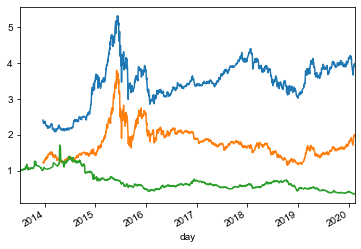

In [15]:
for code in codes:
    print(code)
    df = get_hist_k_data(code, 1500, verbose=True, plot=True)
    df.to_pickle(f'{code}_190215_1500.pkl')

In [9]:
code = 'sz162411'
# code = 'sz159915'


            close        day   high    low   open volume
day                                                     
2013-07-04  1.029 2013-07-04  1.029  1.029  1.029    100
2013-07-05  1.033 2013-07-05  1.033  1.033  1.033    400
            close        day   high    low   open     volume
day                                                         
2020-02-13  0.357 2020-02-13  0.361  0.356   0.36  412058909
2020-02-14  0.355 2020-02-14  0.355  0.353  0.353  384555592


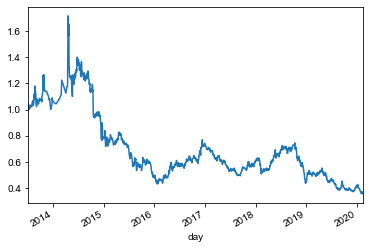

In [10]:
df = get_hist_k_data(code, 1500, verbose=True, plot=True)

## strategy(code, datalen, benjin = 1000, sell_pct=0.1, fee=0.001, dingtou_mode='无脑', sell=True)
定投策略

In [97]:
def strategy(code, datalen, benjin = 1000, sell_pct=0.1, fee=0.001, dingtou_mode='无脑', sell=True):
    """
    每周一3 5 定投1000
    
    dingtou_mode='无脑', '不涨'
    """
    file_name = f'{code}_{datalen}.pkl'
    if os.path.exists(file_name):
        print(f'load file {file_name}')
        df = pd.read_pickle(file_name)
    else:
        print(f'download data...')
        df = get_hist_k_data(code, datalen)
        df.to_pickle(file_name)
    df['weekday'] = df.day.dt.weekday    
    while df.weekday.iloc[0]!=0:  # 从周一开始定投
        df = df.iloc[1:]
    def ft(s):
        return s[-1]/s[0] -1
    df['指数累计涨幅'] = df.close.expanding().agg(ft)
    df1 = df[df.weekday.isin([0, 2, 4])].copy()
    
    df1['benjin'] = 0
    df1.loc[df1.weekday==0, 'benjin'] = benjin
    df1['open_pct'] = df.open/df.open.shift(1)
    if dingtou_mode=='无脑':
        df1.loc[(df1.weekday.isin([2, 4])), 'benjin'] = benjin  # 不管三七二十一 无脑定投
    elif dingtou_mode=='不涨':
        df1.loc[(df1.weekday.isin([2, 4]))&(df1.open_pct<1), 'benjin'] = benjin  # 只要不涨我就增加定投
    
#     print(df1.iloc[:, 1:].head(50))
    df1['num'] = df1.benjin//df1.open//100*100+100
    df1['benjin_real'] = df1.num*df1.open
    
    df1['sell_price'] = df1.open * (1 + sell_pct)
    df1['sell_money'] = df1.num * df1.sell_price * (1-fee)
    
    df1['sell_flag'] = 0  # 表示未卖出 1表示卖出
    df1['sell_flag1'] = 0  # 表示未卖出 1表示卖出
    df1['sell_money1'] = 0  # 统计在那个时点卖出的金额
    if sell:
        df1['net_stoct_num_ac'] = 0
        count = 0
        df1_shape = df1.shape[0]
        for i in range(df1_shape):
            if df1.benjin.iloc[i] > 0 and df1.weekday.iloc[i] in [2, 4]:
                count += 1
                if df1.high.iloc[i:].max()>=df1.sell_price.iloc[i]:
                    df1['sell_flag'].iloc[i] = 1
#             dft = df1.iloc[:(i+1)]  # copy的东西尽量不要做修改，不然会发生一些意想不到的错误
            dft = df1.iloc[:(i+1)].copy()  # 不然就这样显示copy一下
            df1['sell_money1'].iloc[i] = dft.loc[(dft.sell_flag1==0)&(dft.benjin>0)&(dft.sell_price<df1.high.iloc[i])&(dft.weekday.isin([2, 4])), 'sell_money'].sum()
            dft.loc[(dft.sell_flag1==0)&(dft.benjin>0)&(dft.sell_price<df1.high.iloc[i])&(dft.weekday.isin([2, 4])), 'sell_flag1']=1
            df1.sell_flag1.iloc[:(i+1)] = dft.sell_flag1
            df1['net_stoct_num_ac'].iloc[i] = (dft.num * (1-dft.sell_flag1)).sum()
        print(count)
    else:
        df1['net_stoct_num_ac'] = (df1.num * (1-df1.sell_flag1)).expanding().sum()  # 
    df1['单次投入实际金额'] = df1.benjin_real - df1.sell_money1
    print(df1.loc[df1.weekday.isin([2, 4])&(df1.benjin!=0), 'sell_flag'].value_counts())
#     print(df1.loc[df1.weekday.isin([2, 4])&(df1.benjin!=0), 'sell_flag1'].value_counts())
    print((df1.sell_flag1==df1.sell_flag).value_counts())
    df1['t'] = 0
    df1.loc[df1.benjin!=0, 't'] = 1
    df1['累计执行定投次数'] = df1.t.expanding().sum()
#     print('累计执行定投次数: {}'.format(df1[df1.benjin!=0].shape[0]))
    df1['t'] = 0
    df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 't'] = 1
    df1['净执行定投次数'] = df1.t.expanding().sum()
#     print('净执行定投次数: {}'.format(df1[(df1.benjin!=0)&(df1.sell_flag==0)].shape[0]))
    df1['累计投入本金'] = df1.benjin_real.expanding().sum()
#     print('累计投入本金: {}'.format(df1.benjin_real.sum()))
    df1['t'] = 0
    df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 't'] = 1
    df1['t'] = df1.t * df1.benjin_real
    df1['净投入本金'] = df1.t.expanding().sum()
    df1['累计实际净投入本金'] = df1.单次投入实际金额.expanding().sum()  # 买入金额 - 卖出金额
#     net_benjin = df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 'benjin_real'].sum()
#     print('净投入本金: {}---------------------'.format(net_benjin))
    df1['累计买入股数'] = df1.num.expanding().sum()
#     print('累计买入股数: {}'.format(df1.num.sum()))
    df1['t'] = 0
    df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 't'] = 1
    df1['t'] = df1.t * df1.num
    df1['净持股数'] = df1.t.expanding().sum()
#     print('净持股数: {}'.format(df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 'num'].sum()))
    df1['现在持股市值'] = df1.close*df1.净持股数
    df1['现在持股市值_real'] = df1.close*df1.net_stoct_num_ac
#     shizhi = df1.close.iloc[-1]*df1.loc[(df1.benjin!=0)&(df1.sell_flag==0), 'num'].sum()
#     print('现在持股市值: {}'.format(shizhi))
    df1['t'] = df1.sell_flag * df1.sell_price * df1.num * (1-fee)
    df1['累计卖出金额'] = df1.t.expanding().sum()
    df1['累计卖出获利'] = df1['累计卖出金额'] - (df1['累计投入本金']-df1['净投入本金'])
#     sell_val = (df1.sell_flag * df1.sell_price * df1.num ).sum()
#     print('累计卖出金额: {}'.format(sell_val*(1-fee)))
#     print('累计卖出手续费: {}'.format(sell_val*fee))
#     sell_val = sell_val*(1-fee)
    df1['累计绝对收益'] = df1['现在持股市值']+df1['累计卖出金额']-df1['累计投入本金']
    df1['累计绝对收益_real'] = df1['现在持股市值_real']-df1['累计实际净投入本金']
#     print('---------累计绝对收益: {}------------------------------------'.format(shizhi+sell_val-df1.benjin_real.sum()))
#     df1.loc[df1.净投入本金==0, '净投入本金']=benjin
    df1['累计收益率'] = df1['累计绝对收益']/(df1['净投入本金'])
    df1['累计收益率_real'] = df1['累计绝对收益_real']/(df1['累计实际净投入本金'])
    df1['持仓成本'] = (df1['净投入本金']-df1['累计卖出获利'])/df1['净持股数'] 
    df1['持仓成本_real'] = df1['累计实际净投入本金']/df1['net_stoct_num_ac'] 
#     print('累计收益率: {}'.format((shizhi+sell_val-df1.benjin_real.sum())/net_benjin))  
#     print('简单年化收益率: {}'.format(((shizhi+sell_val-df1.benjin_real.sum())/net_benjin)/(datalen/250)))       
    
#     print('期间指数涨幅: {}'.format(zs_ratio)) 
    return df1

In [16]:
code = 'sh510300'
df = pd.read_pickle(f'{code}_190215_1500.pkl')

In [43]:
code = 'sz159915'
df1 = pd.read_pickle(f'{code}_190215_1500.pkl')

In [44]:
df.head()

,close,day,high,low,open,volume
day,,,,,,
2013-12-18,2.407,2013-12-18,2.417,2.403,2.407,301511136
2013-12-19,2.384,2013-12-19,2.419,2.383,2.414,429050368
2013-12-20,2.333,2013-12-20,2.387,2.327,2.386,459476608
2013-12-23,2.333,2013-12-23,2.345,2.307,2.333,259802288
2013-12-24,2.336,2013-12-24,2.364,2.313,2.341,263476448


In [22]:
def t(s):
    return (s.max()-s[0])/s[0]

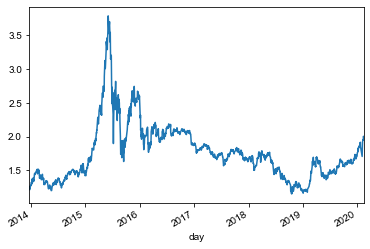

In [46]:
df1.close.plot()

In [42]:
n = 30
dfs = df.close.rolling(n).agg(t).shift(-(n-1))
print(dfs.mean(), dfs.median(), dfs.quantile(q=0.1))


0.05856446173076817 0.04107520386590158 0.0019960079840318427


In [47]:
n = 30
dfs = df1.close.rolling(n).agg(t).shift(-(n-1))
print(dfs.mean(), dfs.median(), dfs.quantile(q=0.1))


0.07895951350097162 0.043741588156123785 0.0


In [51]:
n = 40
dfs = df.close.rolling(n).agg(t).shift(-(n-1))
print(dfs.mean(), dfs.median(), dfs.quantile(q=0.4))

0.07261723715563323 0.05004170141784806 0.03844114528101803


In [52]:
n = 40
dfs = df1.close.rolling(n).agg(t).shift(-(n-1))
print(dfs.mean(), dfs.median(), dfs.quantile(q=0.4))

0.0955775128679586 0.049689440993788865 0.03552077062010833


In [33]:
n = 90
dfs = df.close.rolling(n).agg(t).shift(-(n-1))
print(dfs.mean(), dfs.median(), dfs.quantile(q=0.3))


0.13666419929158963 0.09058134294727359 0.05260430163254737


In [49]:
n = 90
dfs = df1.close.rolling(n).agg(t).shift(-(n-1))
print(dfs.mean(), dfs.median(), dfs.quantile(q=0.3))


0.17179232522508073 0.07633587786259532 0.03370786516853935


In [ ]:
计算标的自买入之日起n天内的最大涨幅
def cal_pct_n(code, n):

# sh510300

## 250

__只买不卖0, 周三五波段35__

In [98]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sh510300'
dff250_0 = strategy(code, 250, 10000, dingtou_mode='无脑', sell=False)

load file sh510300_250.pkl
0    95
Name: sell_flag, dtype: int64
True    147
dtype: int64


In [99]:
dff250_35 = strategy(code, 250, 10000,sell_pct=0.05, dingtou_mode='无脑')

load file sh510300_250.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


95
1    75
0    20
Name: sell_flag, dtype: int64
True    147
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+震荡！  

可以看出：35的成本一直在0的下方，就冲这一点，__35的定投方案是由于0的!__

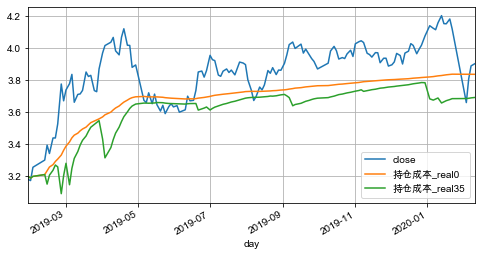

In [154]:
dfm = pd.DataFrame()
dfm['close'] = dff250_0.close
dfm['持仓成本_real0'] = dff250_0.持仓成本_real
dfm['持仓成本_real35'] = dff250_35.持仓成本_real
dfm.plot(figsize=(8, 4), grid=True)

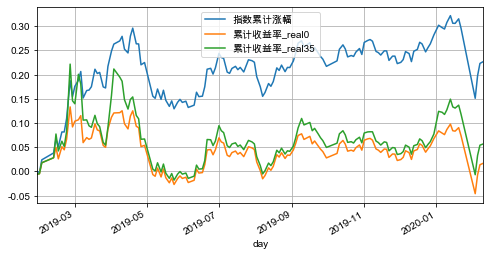

In [155]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff250_0.指数累计涨幅
dfm['累计收益率_real0'] = dff250_0.累计收益率_real
dfm['累计收益率_real35'] = dff250_35.累计收益率_real
dfm.plot(figsize=(8, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

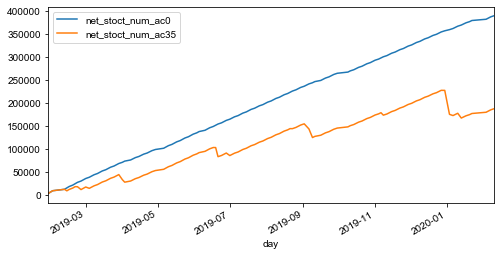

In [112]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff250_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff250_35.net_stoct_num_ac
dfm.plot(figsize=(8, 4))

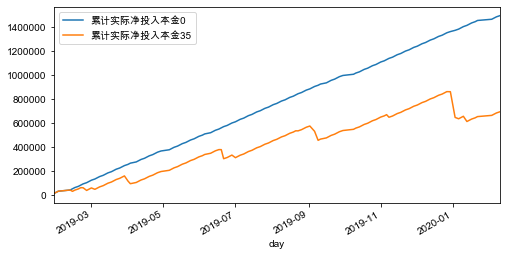

In [113]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff250_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff250_35.累计实际净投入本金
dfm.plot(figsize=(8, 4))

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

绝对收益不是关键问题，可以通过增大定投的金额来解决，如0的方式定投金额是10000，那么35的方式定投金额可以设置为15000，因为35的方式占用的本金比0少，所以少的部分就可以用来做其它事情(放在货币基金，1年还有3%左右的收益呢)。

综上，问题的关键在成本，而35的成本控制比0好，所以35的方案占优！

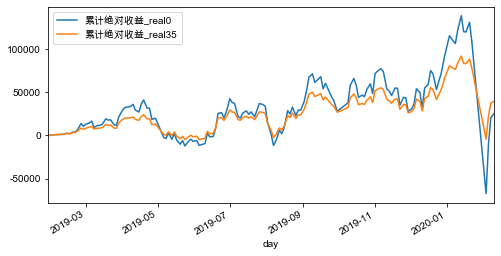

In [114]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff250_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff250_35.累计绝对收益_real
dfm.plot(figsize=(8, 4))

## 500

__只买不卖0, 周三五波段35__

In [115]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sh510300'
dff500_0 = strategy(code, 500, 10000, dingtou_mode='无脑', sell=False)

load file sh510300_500.pkl
0    196
Name: sell_flag, dtype: int64
True    295
dtype: int64


In [116]:
dff500_35 = strategy(code, 500, 10000,sell_pct=0.05, dingtou_mode='无脑')

load file sh510300_500.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


196
1    163
0     33
Name: sell_flag, dtype: int64
True    295
dtype: int64


### 持仓成本&累计收益率
指数近2年的走势拆分一下就是：单边下跌+单边上涨+震荡！  

可以看出：
* 在下跌过程中，35的成本和0差不多，甚至略高于0，但是差距基本可以忽略。
* 单边上涨段，由于35在卖低于成本价的筹码，导致成本略有上升(__这一点考虑一下是否可以优化，低位波段筹码暂时不卖，等到股价高于成本价时，在一起卖出！还可以增加收益，但流动性会变差，也可以妥协一下，35只卖一个波段留一个波段等到股价上穿成本价再卖__！！！)，直到股价上穿成本线，由于开始卖高于成本价的筹码，使得成本快速下降！

也可以看出在指数下跌过程中，定投的抗跌效用。指数跌了30%多，定投最多亏了15%，而且还不是全部本金；

指数底部反弹了%15，定投开始盈利了！

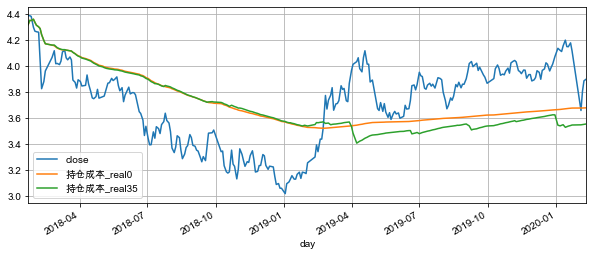

In [144]:
dfm = pd.DataFrame()
dfm['close'] = dff500_0.close
dfm['持仓成本_real0'] = dff500_0.持仓成本_real
dfm['持仓成本_real35'] = dff500_35.持仓成本_real
dfm.plot(figsize=(10, 4), grid=True)

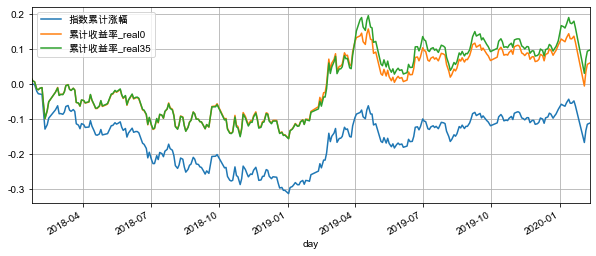

In [145]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff500_0.指数累计涨幅
dfm['累计收益率_real0'] = dff500_0.累计收益率_real
dfm['累计收益率_real35'] = dff500_35.累计收益率_real
dfm.plot(figsize=(10, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

妈呀！！！可以看到投入的本金在买入1年多以后，35的本金不再增多了(遇到了上涨行情，在向1/3总投入本金逼近)。。。

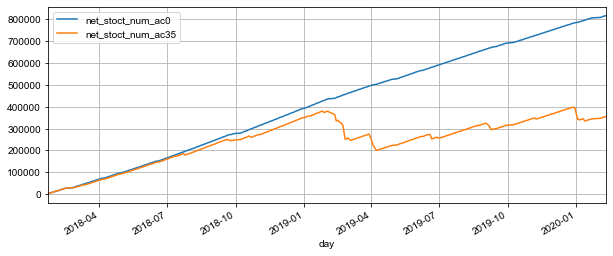

In [146]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff500_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff500_35.net_stoct_num_ac
dfm.plot(figsize=(10, 4), grid=True)

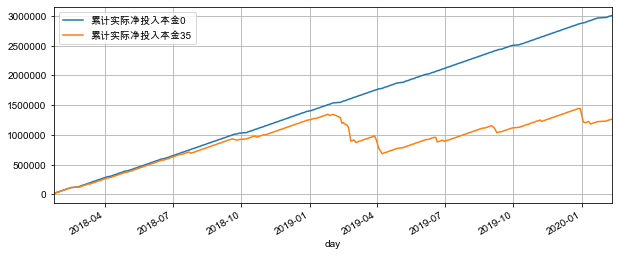

In [147]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff500_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff500_35.累计实际净投入本金
dfm.plot(figsize=(10, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

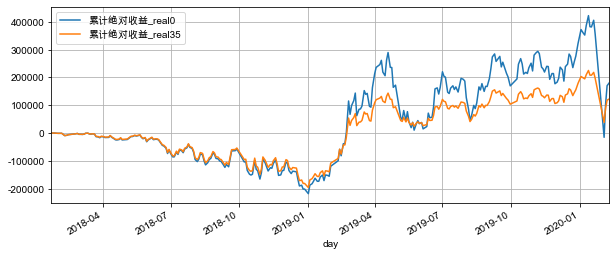

In [143]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff500_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff500_35.累计绝对收益_real
dfm.plot(figsize=(10, 4), grid=True)

## 750

__只买不卖0, 周三五波段35__

In [122]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sh510300'
dff750_0 = strategy(code, 750, 10000, dingtou_mode='无脑', sell=False)

load file sh510300_750.pkl
0    299
Name: sell_flag, dtype: int64
True    445
dtype: int64


In [123]:
dff750_35 = strategy(code, 750, 10000,sell_pct=0.05, dingtou_mode='无脑')

load file sh510300_750.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


299
1    261
0     38
Name: sell_flag, dtype: int64
True    445
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+单边下跌+单边上涨+震荡！  

可以看出：
单边上涨+单边下跌：构成一个倒V,这个对于定投是最不好的一个图形！一定要想方设法在高位的时候进一步降低仓位！

不然在倒V结束时，因为时间足够长了，已经投入了很大的本金，再亏损的时候虽然看似比例很少，其绝对金额也不小！！！

所以要严格甄别倒V的顶部区域，在顶部区域做一次大的平衡，来降低仓位！！！一方面成本降下来了更不易亏损，另一方面即使亏损，由于仓位不高，其绝对亏损也能够承受。而且后续也有足够的本金接着定投！！！

__长时间定投造成仓位越来越高，在上涨势和震荡市中，只要有一定的盈利，可以定期做一下平衡，增大安全区间；__
如：在收益率达到10%，20%，40%等都做一下平衡！

__而长时间的下跌势则只能硬抗了__

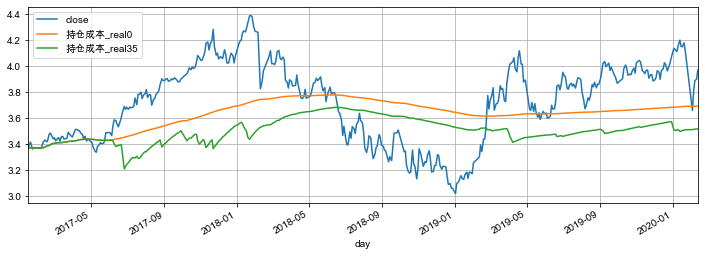

In [148]:
dfm = pd.DataFrame()
dfm['close'] = dff750_0.close
dfm['持仓成本_real0'] = dff750_0.持仓成本_real
dfm['持仓成本_real35'] = dff750_35.持仓成本_real
dfm.plot(figsize=(12, 4), grid=True)

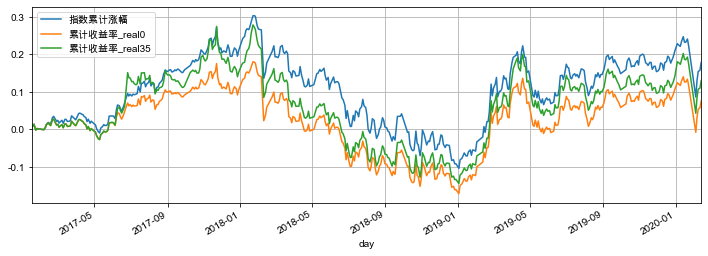

In [149]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff750_0.指数累计涨幅
dfm['累计收益率_real0'] = dff750_0.累计收益率_real
dfm['累计收益率_real35'] = dff750_35.累计收益率_real
dfm.plot(figsize=(12, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

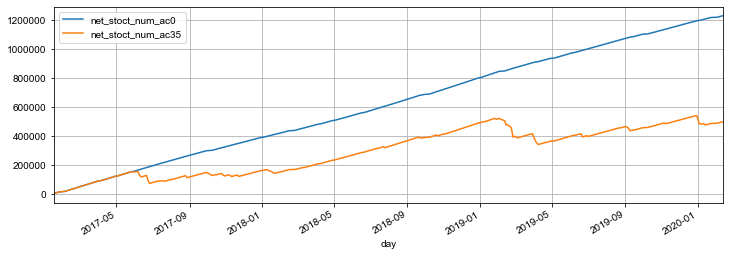

In [151]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff750_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff750_35.net_stoct_num_ac
dfm.plot(figsize=(12, 4), grid=True)

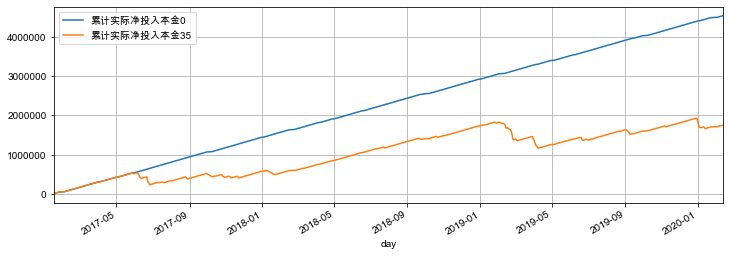

In [152]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff750_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff750_35.累计实际净投入本金
dfm.plot(figsize=(12, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

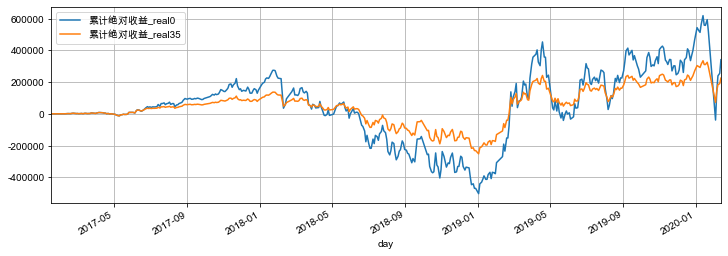

In [153]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff750_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff750_35.累计绝对收益_real
dfm.plot(figsize=(12, 4), grid=True)

## 1000

__只买不卖0, 周三五波段35__

In [129]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sh510300'
dff1000_0 = strategy(code, 1000, 10000, dingtou_mode='无脑', sell=False)

load file sh510300_1000.pkl
0    401
Name: sell_flag, dtype: int64
True    596
dtype: int64


In [130]:
dff1000_35 = strategy(code, 1000, 10000,sell_pct=0.05, dingtou_mode='无脑')

load file sh510300_1000.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


401
1    363
0     38
Name: sell_flag, dtype: int64
True    596
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+震荡！  

可以看出：35的成本一直在0的下方，就冲这一点，__35的定投方案是由于0的!__

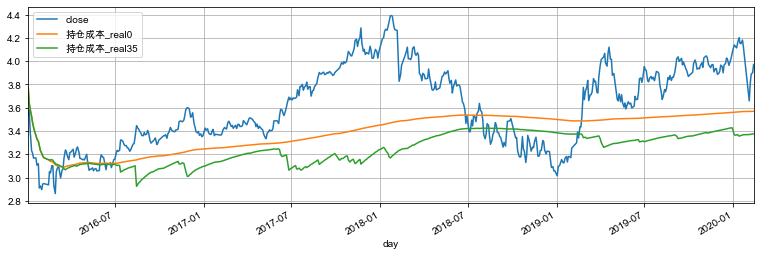

In [156]:
dfm = pd.DataFrame()
dfm['close'] = dff1000_0.close
dfm['持仓成本_real0'] = dff1000_0.持仓成本_real
dfm['持仓成本_real35'] = dff1000_35.持仓成本_real
dfm.plot(figsize=(13, 4), grid=True)

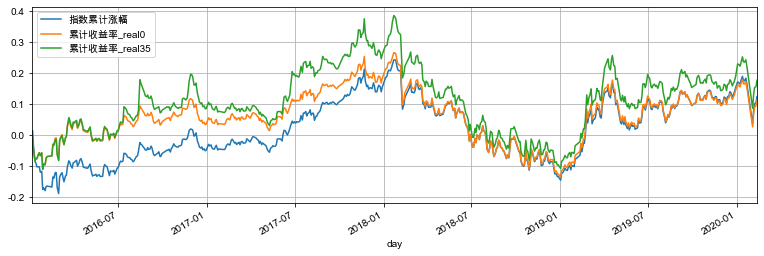

In [157]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff1000_0.指数累计涨幅
dfm['累计收益率_real0'] = dff1000_0.累计收益率_real
dfm['累计收益率_real35'] = dff1000_35.累计收益率_real
dfm.plot(figsize=(13, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

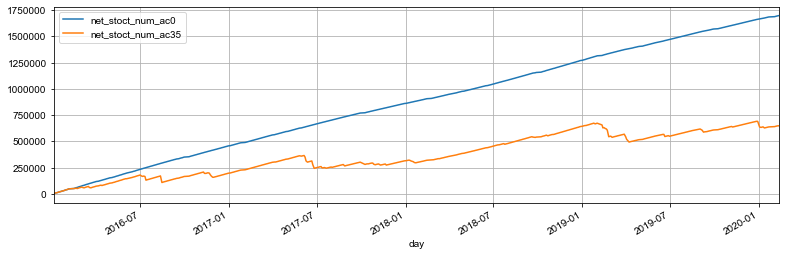

In [160]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff1000_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff1000_35.net_stoct_num_ac
dfm.plot(figsize=(13, 4), grid=True)

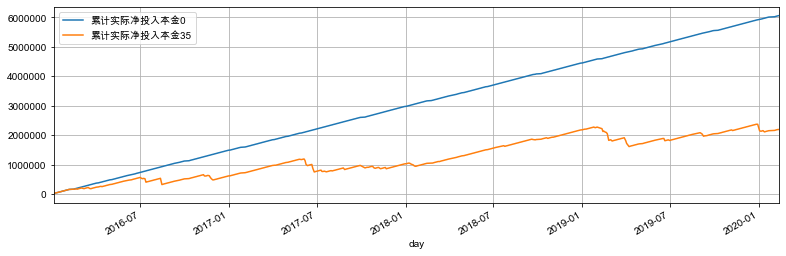

In [158]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff1000_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff1000_35.累计实际净投入本金
dfm.plot(figsize=(13, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

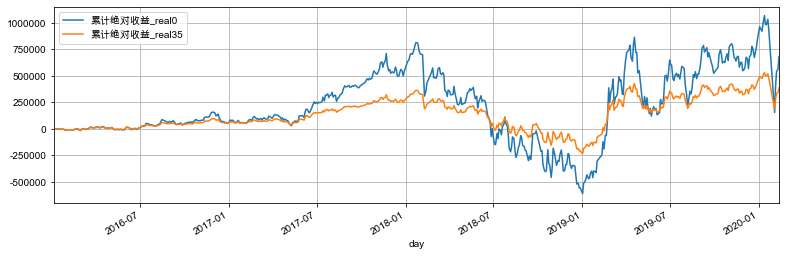

In [159]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff1000_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff1000_35.累计绝对收益_real
dfm.plot(figsize=(13, 4), grid=True)

## 1250

__只买不卖0, 周三五波段35__

In [136]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sh510300'
dff1250_0 = strategy(code, 1250, 10000, dingtou_mode='无脑', sell=False)

load file sh510300_1250.pkl
0    499
Name: sell_flag, dtype: int64
True    743
dtype: int64


In [137]:
dff1250_35 = strategy(code, 1250, 10000,sell_pct=0.05, dingtou_mode='无脑')

load file sh510300_1250.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


499
1    450
0     49
Name: sell_flag, dtype: int64
True    743
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+震荡！  

可以看出：35的成本一直在0的下方，就冲这一点，__35的定投方案是由于0的!__

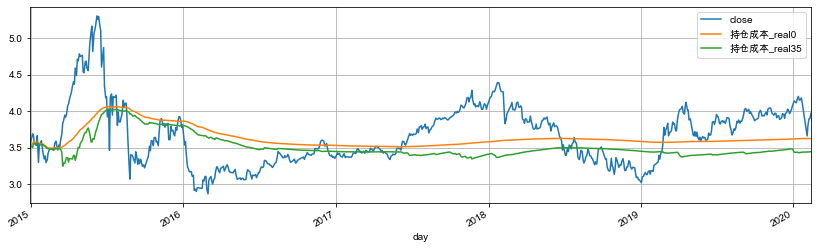

In [161]:
dfm = pd.DataFrame()
dfm['close'] = dff1250_0.close
dfm['持仓成本_real0'] = dff1250_0.持仓成本_real
dfm['持仓成本_real35'] = dff1250_35.持仓成本_real
dfm.plot(figsize=(14, 4), grid=True)

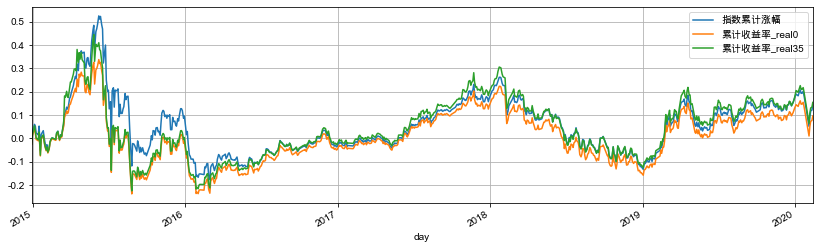

In [162]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff1250_0.指数累计涨幅
dfm['累计收益率_real0'] = dff1250_0.累计收益率_real
dfm['累计收益率_real35'] = dff1250_35.累计收益率_real
dfm.plot(figsize=(14, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

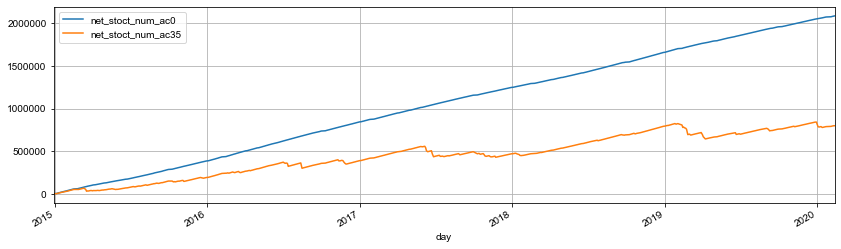

In [163]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff1250_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff1250_35.net_stoct_num_ac
dfm.plot(figsize=(14, 4), grid=True)

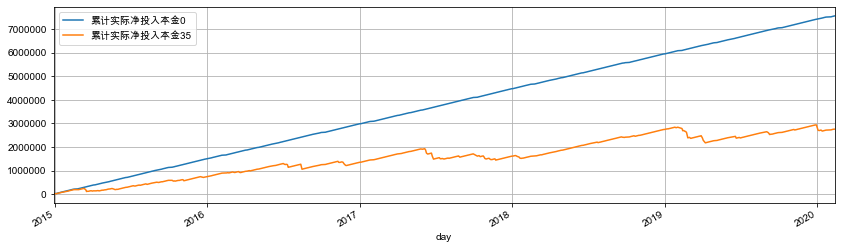

In [164]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff1250_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff1250_35.累计实际净投入本金
dfm.plot(figsize=(14, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

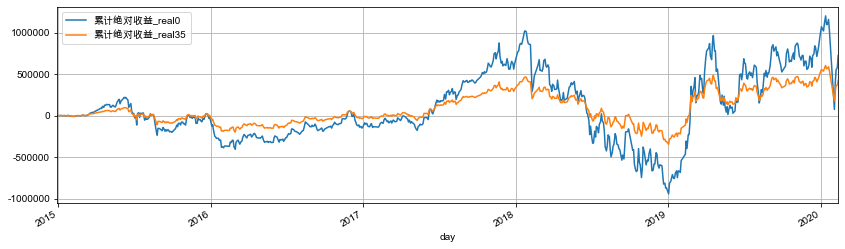

In [165]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff1250_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff1250_35.累计绝对收益_real
dfm.plot(figsize=(14, 4), grid=True)

# sz159915

## 250

__只买不卖0, 周三五波段35__

In [168]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sz159915'
pct = 0.1
dff250_0 = strategy(code, 250, 10000, dingtou_mode='无脑', sell=False)

load file sz159915_250.pkl
0    95
Name: sell_flag, dtype: int64
True    147
dtype: int64


In [169]:
dff250_35 = strategy(code, 250, 10000,sell_pct=pct, dingtou_mode='无脑')

load file sz159915_250.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


95
1    88
0     7
Name: sell_flag, dtype: int64
True    147
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+震荡！  

可以看出：35的成本一直在0的下方，就冲这一点，__35的定投方案是由于0的!__

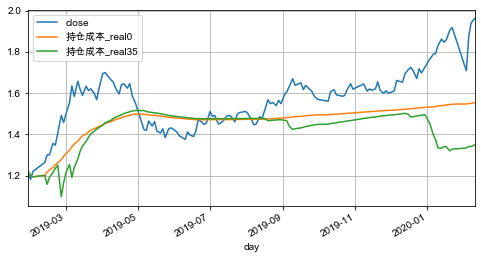

In [170]:
dfm = pd.DataFrame()
dfm['close'] = dff250_0.close
dfm['持仓成本_real0'] = dff250_0.持仓成本_real
dfm['持仓成本_real35'] = dff250_35.持仓成本_real
dfm.plot(figsize=(8, 4), grid=True)

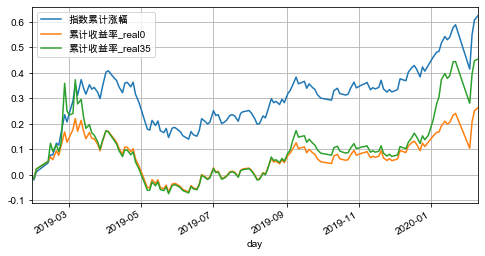

In [171]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff250_0.指数累计涨幅
dfm['累计收益率_real0'] = dff250_0.累计收益率_real
dfm['累计收益率_real35'] = dff250_35.累计收益率_real
dfm.plot(figsize=(8, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

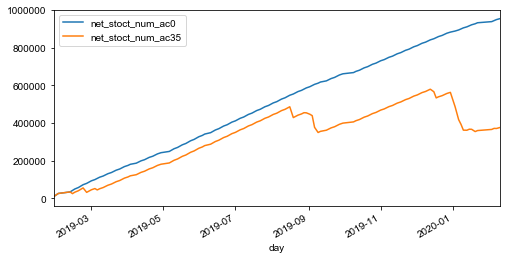

In [172]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff250_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff250_35.net_stoct_num_ac
dfm.plot(figsize=(8, 4))

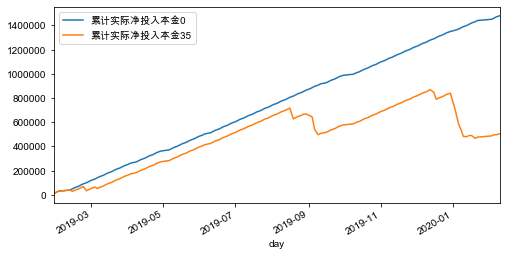

In [173]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff250_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff250_35.累计实际净投入本金
dfm.plot(figsize=(8, 4))

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

绝对收益不是关键问题，可以通过增大定投的金额来解决，如0的方式定投金额是10000，那么35的方式定投金额可以设置为15000，因为35的方式占用的本金比0少，所以少的部分就可以用来做其它事情(放在货币基金，1年还有3%左右的收益呢)。

综上，问题的关键在成本，而35的成本控制比0好，所以35的方案占优！

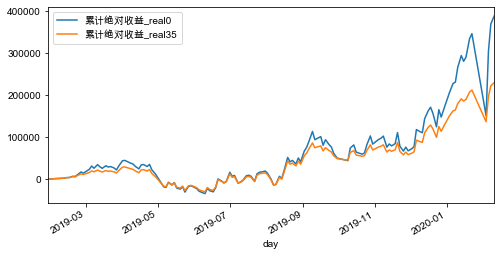

In [174]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff250_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff250_35.累计绝对收益_real
dfm.plot(figsize=(8, 4))

## 500

__只买不卖0, 周三五波段35__

In [175]:
# 如果只买不卖，在震荡市里会被打爆！
dff500_0 = strategy(code, 500, 10000, dingtou_mode='无脑', sell=False)

download data...
0    197
Name: sell_flag, dtype: int64
True    296
dtype: int64


In [176]:
dff500_35 = strategy(code, 500, 10000,sell_pct=pct, dingtou_mode='无脑')

load file sz159915_500.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


197
1    190
0      7
Name: sell_flag, dtype: int64
True    296
dtype: int64


### 持仓成本&累计收益率
指数近2年的走势拆分一下就是：单边下跌+单边上涨+震荡！  

可以看出：
* 在下跌过程中，35的成本和0差不多，甚至略高于0，但是差距基本可以忽略。
* 单边上涨段，由于35在卖低于成本价的筹码，导致成本略有上升(__这一点考虑一下是否可以优化，低位波段筹码暂时不卖，等到股价高于成本价时，在一起卖出！还可以增加收益，但流动性会变差，也可以妥协一下，35只卖一个波段留一个波段等到股价上穿成本价再卖__！！！)，直到股价上穿成本线，由于开始卖高于成本价的筹码，使得成本快速下降！

也可以看出在指数下跌过程中，定投的抗跌效用。指数跌了30%多，定投最多亏了15%，而且还不是全部本金；

指数底部反弹了%15，定投开始盈利了！

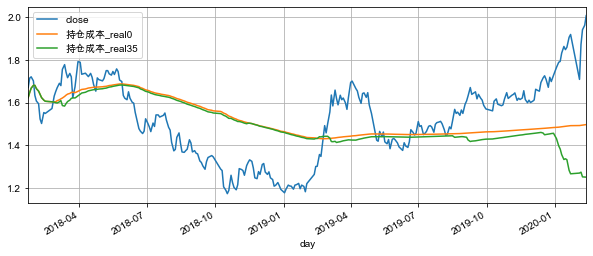

In [177]:
dfm = pd.DataFrame()
dfm['close'] = dff500_0.close
dfm['持仓成本_real0'] = dff500_0.持仓成本_real
dfm['持仓成本_real35'] = dff500_35.持仓成本_real
dfm.plot(figsize=(10, 4), grid=True)

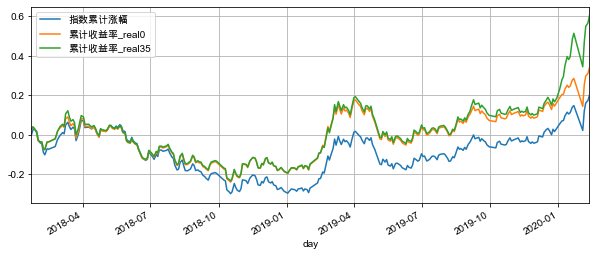

In [178]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff500_0.指数累计涨幅
dfm['累计收益率_real0'] = dff500_0.累计收益率_real
dfm['累计收益率_real35'] = dff500_35.累计收益率_real
dfm.plot(figsize=(10, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

妈呀！！！可以看到投入的本金在买入1年多以后，35的本金不再增多了(遇到了上涨行情，在向1/3总投入本金逼近)。。。

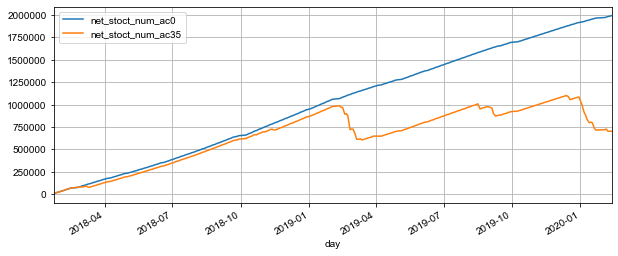

In [179]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff500_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff500_35.net_stoct_num_ac
dfm.plot(figsize=(10, 4), grid=True)

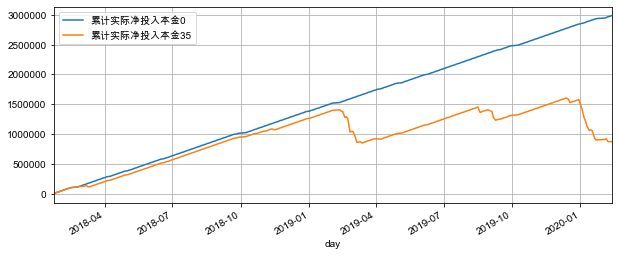

In [180]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff500_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff500_35.累计实际净投入本金
dfm.plot(figsize=(10, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

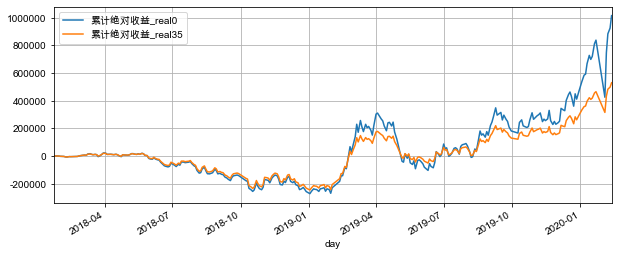

In [181]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff500_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff500_35.累计绝对收益_real
dfm.plot(figsize=(10, 4), grid=True)

## 750

__只买不卖0, 周三五波段35__

In [186]:
# 如果只买不卖，在震荡市里会被打爆！
code = 'sz159915'
dff750_0 = strategy(code, 750, 10000, dingtou_mode='无脑', sell=False)

download data...
0    299
Name: sell_flag, dtype: int64
True    445
dtype: int64


In [187]:
dff750_35 = strategy(code, 750, 10000,sell_pct=pct, dingtou_mode='无脑')

load file sz159915_750.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


299
1    276
0     23
Name: sell_flag, dtype: int64
True    445
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+单边下跌+单边上涨+震荡！  

可以看出：
单边上涨+单边下跌：构成一个倒V,这个对于定投是最不好的一个图形！一定要想方设法在高位的时候进一步降低仓位！

不然在倒V结束时，因为时间足够长了，已经投入了很大的本金，再亏损的时候虽然看似比例很少，其绝对金额也不小！！！

所以要严格甄别倒V的顶部区域，在顶部区域做一次大的平衡，来降低仓位！！！一方面成本降下来了更不易亏损，另一方面即使亏损，由于仓位不高，其绝对亏损也能够承受。而且后续也有足够的本金接着定投！！！

__长时间定投造成仓位越来越高，在上涨势和震荡市中，只要有一定的盈利，可以定期做一下平衡，增大安全区间；__
如：在收益率达到10%，20%，40%等都做一下平衡！

__而长时间的下跌势则只能硬抗了__

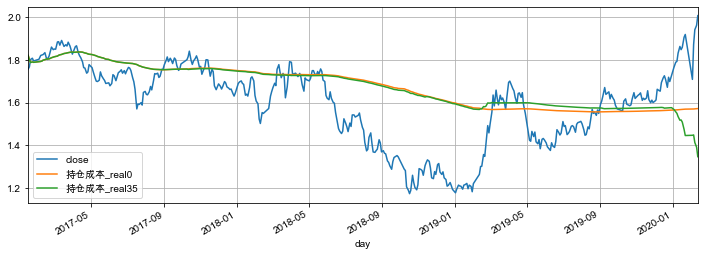

In [188]:
dfm = pd.DataFrame()
dfm['close'] = dff750_0.close
dfm['持仓成本_real0'] = dff750_0.持仓成本_real
dfm['持仓成本_real35'] = dff750_35.持仓成本_real
dfm.plot(figsize=(12, 4), grid=True)

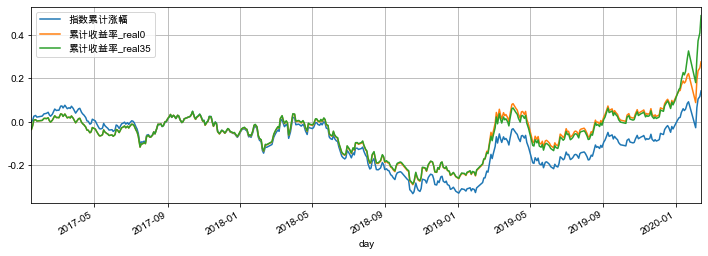

In [189]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff750_0.指数累计涨幅
dfm['累计收益率_real0'] = dff750_0.累计收益率_real
dfm['累计收益率_real35'] = dff750_35.累计收益率_real
dfm.plot(figsize=(12, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

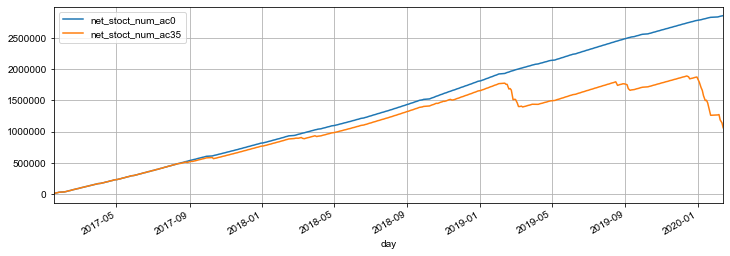

In [190]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff750_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff750_35.net_stoct_num_ac
dfm.plot(figsize=(12, 4), grid=True)

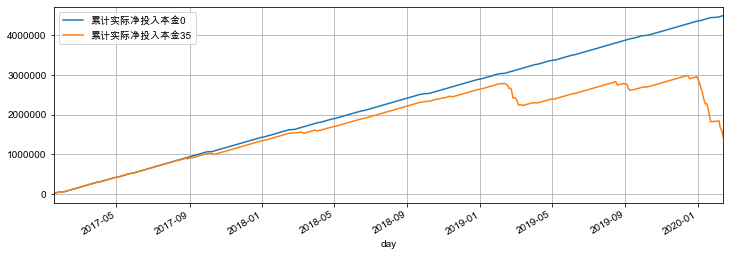

In [191]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff750_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff750_35.累计实际净投入本金
dfm.plot(figsize=(12, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

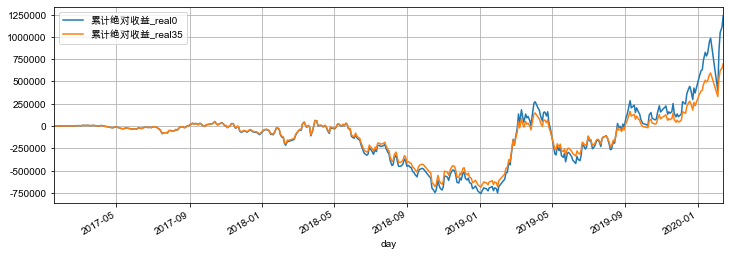

In [192]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff750_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff750_35.累计绝对收益_real
dfm.plot(figsize=(12, 4), grid=True)

## 1000

__只买不卖0, 周三五波段35__

In [193]:
# 如果只买不卖，在震荡市里会被打爆！
dff1000_0 = strategy(code, 1000, 10000, dingtou_mode='无脑', sell=False)

download data...
0    401
Name: sell_flag, dtype: int64
True    596
dtype: int64


In [194]:
dff1000_35 = strategy(code, 1000, 10000,sell_pct=pct, dingtou_mode='无脑')

load file sz159915_1000.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


401
1    295
0    106
Name: sell_flag, dtype: int64
True    596
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+震荡！  

可以看出：35的成本一直在0的下方，就冲这一点，__35的定投方案是由于0的!__

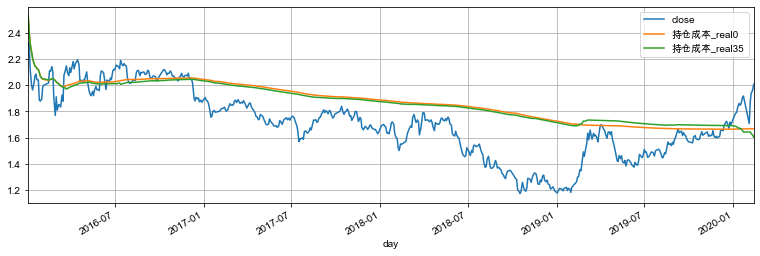

In [195]:
dfm = pd.DataFrame()
dfm['close'] = dff1000_0.close
dfm['持仓成本_real0'] = dff1000_0.持仓成本_real
dfm['持仓成本_real35'] = dff1000_35.持仓成本_real
dfm.plot(figsize=(13, 4), grid=True)

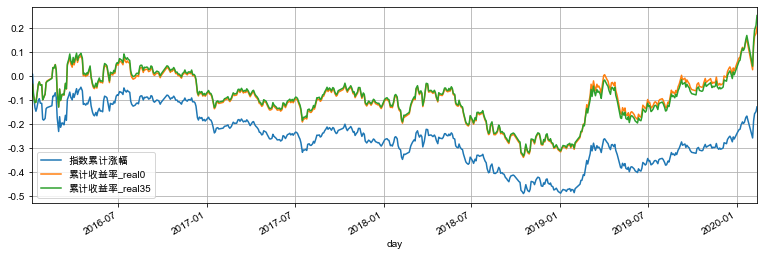

In [196]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff1000_0.指数累计涨幅
dfm['累计收益率_real0'] = dff1000_0.累计收益率_real
dfm['累计收益率_real35'] = dff1000_35.累计收益率_real
dfm.plot(figsize=(13, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

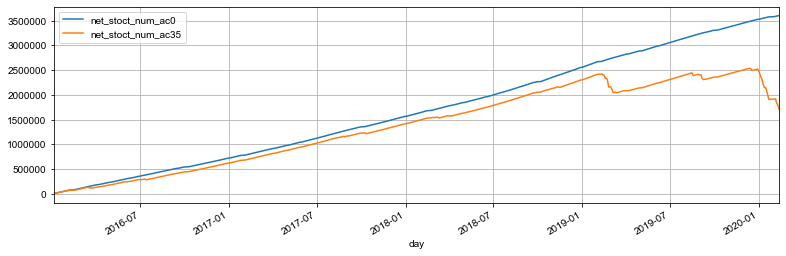

In [197]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff1000_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff1000_35.net_stoct_num_ac
dfm.plot(figsize=(13, 4), grid=True)

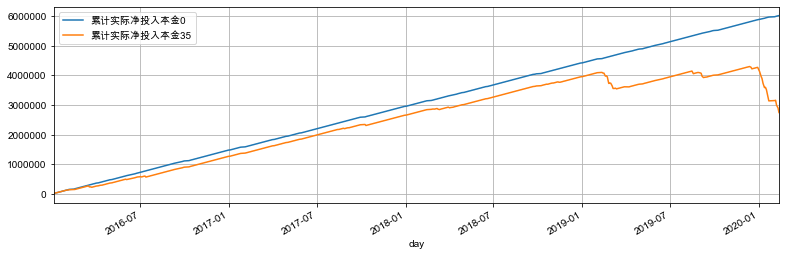

In [198]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff1000_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff1000_35.累计实际净投入本金
dfm.plot(figsize=(13, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

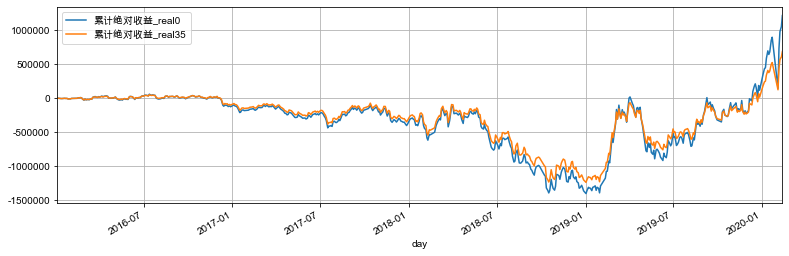

In [199]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff1000_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff1000_35.累计绝对收益_real
dfm.plot(figsize=(13, 4), grid=True)

## 1250

__只买不卖0, 周三五波段35__

In [200]:
# 如果只买不卖，在震荡市里会被打爆！
dff1250_0 = strategy(code, 1250, 10000, dingtou_mode='无脑', sell=False)

download data...
0    499
Name: sell_flag, dtype: int64
True    743
dtype: int64


In [201]:
dff1250_35 = strategy(code, 1250, 10000,sell_pct=pct, dingtou_mode='无脑')

load file sz159915_1250.pkl


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


499
1    364
0    135
Name: sell_flag, dtype: int64
True    743
dtype: int64


### 持仓成本&累计收益率
指数近一年的走势拆分一下就是：单边上涨+震荡！  

可以看出：35的成本一直在0的下方，就冲这一点，__35的定投方案是由于0的!__

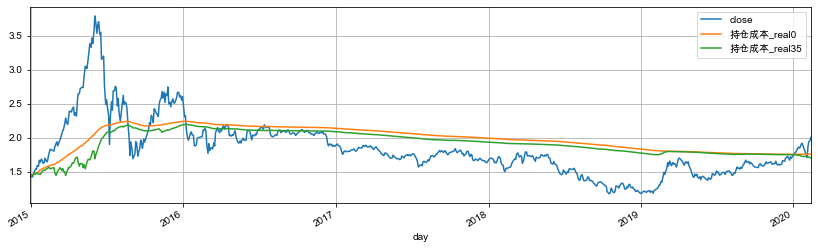

In [202]:
dfm = pd.DataFrame()
dfm['close'] = dff1250_0.close
dfm['持仓成本_real0'] = dff1250_0.持仓成本_real
dfm['持仓成本_real35'] = dff1250_35.持仓成本_real
dfm.plot(figsize=(14, 4), grid=True)

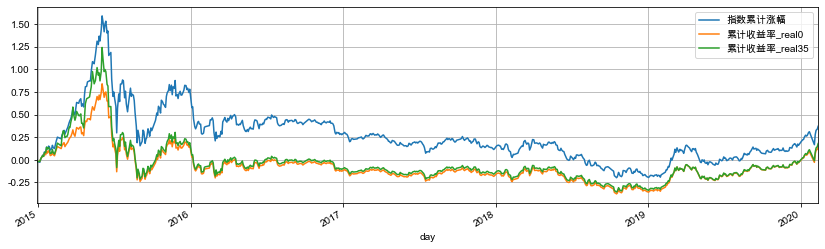

In [203]:
dfm = pd.DataFrame()
dfm['指数累计涨幅'] = dff1250_0.指数累计涨幅
dfm['累计收益率_real0'] = dff1250_0.累计收益率_real
dfm['累计收益率_real35'] = dff1250_35.累计收益率_real
dfm.plot(figsize=(14, 4), grid=True)

### 持股数&净投入本金
* 单边上涨的净持股数：35是0的1/3；
* 单边下跌的净持股数：35和0是一样的；
* 所以，$\alpha = 35的净持股数:0的净持股数\in [1/3, 1]$  
如果是上涨行情，$\alpha$会变小，下跌行情$\alpha$会变大  
* 再定义一个$资金周转率\beta=1-\alpha \in [0, 2/3]$  
当然是希望周转率$\beta$越大越好, 也就是$\alpha$越小越好！

在选取的近一年的数据中$\alpha$略大于1/2

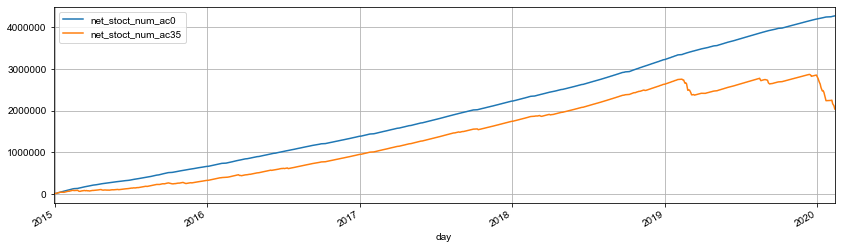

In [204]:
dfm = pd.DataFrame()
dfm['net_stoct_num_ac0'] = dff1250_0.net_stoct_num_ac
dfm['net_stoct_num_ac35'] = dff1250_35.net_stoct_num_ac
dfm.plot(figsize=(14, 4), grid=True)

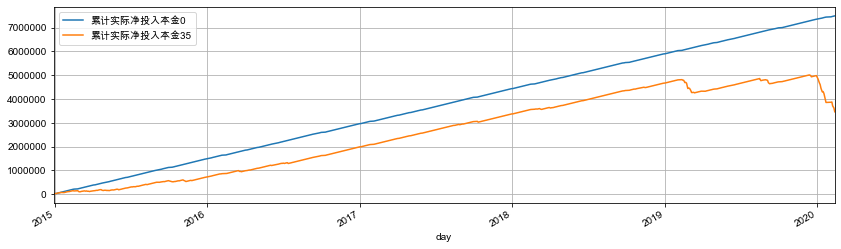

In [205]:
dfm = pd.DataFrame()
dfm['累计实际净投入本金0'] = dff1250_0.累计实际净投入本金
dfm['累计实际净投入本金35'] = dff1250_35.累计实际净投入本金
dfm.plot(figsize=(14, 4), grid=True)

### 绝对收益
* 在单边上涨行情中, 35的绝对收益是0的绝对收益的(1/3 + 1/30)=0.367  
35的持股数是0的1/3，持仓成本是0的(1-2*pct)=0.9, 35没有做波段的绝对收益是0的1/3, 35做波段的收益是1/3*(1-0.9)=1/30
* 在单边下跌行情中，35的绝对收益:0的绝对收益=1
* 在理想震荡行情中，35的绝对收益:0的绝对收益=无穷大
0的绝对收益=0，35的绝对收益=0的投入本金*1/3*(1-0.9)=0的投入本金*0.033

可以看出，在震荡行情中，35的优势是明显的！由于股市的行情都可以分解为上涨+震荡+下跌，震荡的时间是最长的，所以35占优！

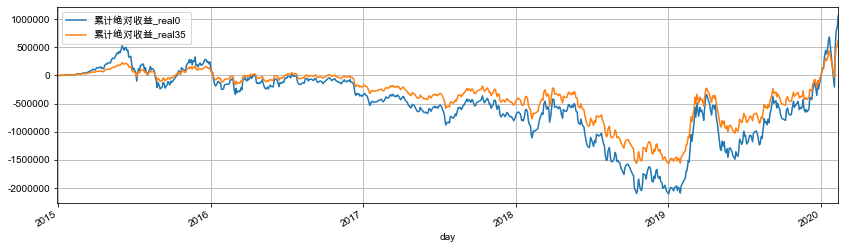

In [206]:
dfm = pd.DataFrame()
dfm['累计绝对收益_real0'] = dff1250_0.累计绝对收益_real
dfm['累计绝对收益_real35'] = dff1250_35.累计绝对收益_real
dfm.plot(figsize=(14, 4), grid=True)

# 定投文章
我是看了lxl的定投文章https://onregularinvesting.com/#/cn/ 开始关注定投的！

## 定投主要解决的问题
### 让我有了把大量的金钱安心的投入到股市中的可能！
如果投入股市的钱很少，那对于我是没有意义的。我希望股市作为我的第二职业，第二个赚钱的来源！

如果投入股市的钱很多，又会引起我极大的焦虑！这种焦虑会极大的消耗我的时间和精力！
如果不靠定投，就是目前现在我的状态：股票大跌的时候，不卖就不错了，哪敢加仓！股票大涨的时候，心态也很差，拿不住！
把大量的钱，甚至是全部的前投入到股市中，这一点很重要，假如投入100w，赚10%是10w，而投入50w，赚20%才是10w！

### 可以节省我大量的精力！
如果我投资个股，每天都看盘，而且心态很差，严重的影响到工作！
而定投的话，我的心态很平和，定期以开盘价买入，然后把该挂的单挂出去，完全可以不再看盘！
心态平和的话，可以有很好的精力去干其它事情！

## 定投+波段解决的问题和使用场景
当然定投并非没有问题。和一次性投入比较，定投的本质是平均化成本，而非降低成本！

所以定投解决的问题是在一个整体低估的环境中，如何把钱安全的投进去！如果整体并不低估、甚至是高估，那么定投显然是赚不到钱的！！！

* 常常在明显低估的环境中，想办法把钱以不高的成本投进去其实并不容易！
虽然标的已经明显低估，但是并不排除后面依然会下跌，甚至下跌很多，或者很长时间都不涨。
    * 如果一次性投进去，那面临的可能是后面的下跌只能生扛，而没钱补仓；或者即使不跌，如果长时间不涨的话，也会面临长时间没有收益的尴尬！
    * 如果是定投+波段，则没有这样的烦恼，定投可以在下跌段不断的降低成本；而波段使得即使标的长时间不涨依然可以降低成本！

那看似完美的解决方案有哪些问题呢？
* 正如前所说，定投一定要在一个整体低估的环境中使用，不然不会有好的效果！
* 如果定投的时间很长，那么后面的定投对于成本的降低作用会减弱。为了定投有持续性，就要在定投较长的一段时间后，不提高成本的前提下(即现在处于不亏的状态)，对本金整体做一次平衡，这样做，一是保证定投的可持续性，而是在下跌来临时，使得定投能有效的降低成本！
* 如何开始定投
    * 如果当前是下跌市，先以很低的定投金额开始定投，等到下跌段结束，慢慢进入震荡市，再逐步增加定投金额
    * 如果当前是震荡市，则正常参与，但是要注意平衡成本
    * 如果当前是上涨市，则正常参与，但是要注意平衡成本






## 不同的走势对于定投+波段策略的影响

按照对定投+波段最有利-最差进行排序
* 震荡+上涨： 
震荡的时间越长，越有利，整个过程中基本上不会产生较大的亏损
* 下跌+上涨：
下跌会产生亏损，好处是会使得成本下降，后续的上涨会赚的更多
* 单边上涨
这个一直会产生盈利，坏处是成本也会不断升高。如果上涨结束进入下跌，会很快亏损。。。现在没有很好的办法应对！！！
* 震荡
这个的好处是不会有大的亏损，应该还会有一些利润。面临的风险是如果时间太长，则需要进行本金平衡，以应对后续可能的下跌！
* 震荡+下跌
* 上涨+下跌
* 单边下跌
如果下跌的时间过长(如16-19年的创业板，指数跌了50%，采用定投最差的时候收益为-30%)，连进行本金平衡的机会都没有！

这种情况是必须避免的：
* 一是在定投时机的选择上，要避开处在高位的股票
这个其实很难，回头看16年初的创业板，位置高么？刚在短短的3个月内涨了60-70%，相比于15年的牛市高点还有很长的距离，所以，说是避开处理处于高位的股票，实际上根本就是很难做到的！
* 找几只相关性较低的股票进行定投，才是避免风险的王道！


# 现在的策略
## 第一阶段策略200210
* sh510300 定投5000
* sz510915 定投5000
已经执行了3次

主要的问题是：
* sh510300&sz510915相关性很高，
* sh510300&sz510915目前定投的位置也不太好，两个基金都在底部有了很大的涨幅

## 第二阶段策略200215
增加sz162411，一方面是不相关性高，二是目前的位置下跌很久了，感觉也挺合适的
* sh510300 定投5000
* sz510915 定投4000
* sz162411 定投1000

200217执行  
* sh510300 定投5000
* sz510915 定投1000  
对之前的3次进行平衡操作
* sz162411 定投4000  
补足之前3次的仓位

后续按照策略恢复操作

# ETF相关知识

## 国内ETF一共有多少只？其中已经上市的ETF数量是多少？
* 上交所
    * ETF列表：http://www.sse.com.cn/assortment/fund/etf/list/
    * 指数对应的成分股：http://www.sse.com.cn/assortment/fund/list/etfinfo/redemptionlist/index.shtml?FUNDID=510630
* 深交所
    * ETF列表：http://www.szse.cn/market/fund/list/etfList/index.html
    * 指数与样本股：http://www.szse.cn/market/exponent/sample/index.html